# Minimal example of SyncRad usage
## Undulator radiation

In [1]:
# Imports

%matplotlib notebook
import matplotlib.pyplot as plt

import sys, time
import numpy as np

from synchrad.calc import SynchRad
from synchrad.utils import J_in_um

In [2]:
# Undulator
K0 = 0.1  # Strength
Periods = 50  # Number of periods

# Particles and tracks characteristics
Np = 24  # Number of particles
g0 = 100.0  # Mean Lorentz factor
dg = 1e-4 * g0  # Energy spread
StepsPerPeriod = 32  # Track temporal resolution

# Mean particles longitudinal velocity and central wavenumber
gg = g0 / (1.0 + K0 ** 2 / 2) ** 0.5
vb = (1.0 - gg ** -2) ** 0.5
k_res = 2 * gg ** 2

# Time step and total number of steps
dt = 1.0 / StepsPerPeriod
Steps2Do = int((Periods + 2) / dt) + 1

# Undulator field distribution
def uxFunctionUndulator(z):
    val = K0 * np.sin(2 * np.pi * z)
    val *= (z > 0) * (z < 1.5) * z / 1.5 + (z > 1.5)
    val *= (z > Periods - 1.5) * (z < Periods) * (Periods - z) / 1.5 + (
        z < Periods - 1.5
    )
    return val

In [3]:
# Calculating the particles orbits (simplified)

t = np.r_[-1 : Periods + 1 : Steps2Do * 1j]
y = np.zeros_like(t)
uy = np.zeros_like(t)
w = 1.0

particleTracks = []
for g0_p in g0 + dg * np.random.randn(Np):
    gg = g0_p / (1.0 + K0 ** 2 / 2) ** 0.5
    vb = (1.0 - gg ** -2) ** 0.5
    z = vb * t
    ux = uxFunctionUndulator(z - 0.5 * dt)
    uz = (g0 ** 2 - 1 - ux ** 2) ** 0.5
    x = ux[0] / g0_p * dt / 2 + np.cumsum(ux / g0_p) * dt

    particleTracks.append([x, y, z, ux, uy, uz, w])

In [4]:
calc_input = {
    "grid": [
        (0.02 * k_res, 1.1 * k_res),  # Wavenumber mapping region
        (0, 2.0 / g0),                # Elevation (theta) angle region
        (0.0, 2 * np.pi),             # Rotation (phi) angle
        (256, 64, 64),                # Corresponding resolutions
    ],  
    "timeStep": dt,                   # normalized timestep
    'ctx':[0,0]                       # OpenCL context (leave commented to be asked)
}

calc = SynchRad(calc_input)

Running on 1 devices
  GPU device: GeForce GTX 1080 Ti
Platform: NVIDIA Corporation
Compiler: OpenCL C 1.2 


In [5]:
t0 = time.time()
calc.calculate_spectrum(particleTracks, comp='total', Np_max=Np)

print('Done {:s}field spectrum from {:d} particle(s) in {:g} sec'\
      .format( calc.Args['mode'], Np,(time.time()-t0)))

energyModel = calc.get_energy(lambda0_um=1)

energyTheory = Np * k_res*J_in_um*(7*np.pi/24)/137.*K0**2*(1+K0**2/2)*Periods
var = abs(energyModel - energyTheory)/energyTheory
print("Deviation from analytic estimate is {:.2f}%".format(var*100))

Done farfield spectrum from 24 particle(s) in 25.0256 sec
Deviation from analytic estimate is 2.94%


<IPython.core.display.Javascript object>


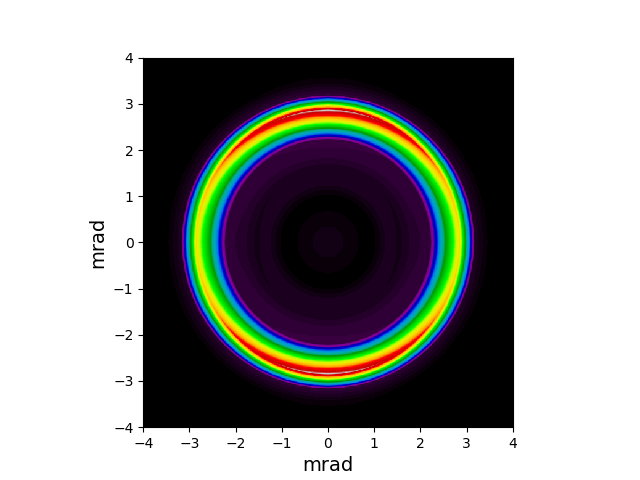

In [6]:
# Plot the spot observed with a band-filter

kFilter = 0.93 * k_res
kBand = 0.003 * kFilter
k = calc.Args['omega'][:,None,None]
spect_filter = np.exp( -(k-kFilter)**2/kBand**2 ) 

spot, extent = calc.get_spot_cartesian(bins=(600,600), lambda0_um=2e4,
                                       th_part=0.2, spect_filter=spect_filter)

plt.figure()
plt.imshow(spot.T, extent=extent*1e3, cmap=plt.cm.nipy_spectral )
[ lab('mrad', size=14) for lab in (plt.xlabel, plt.ylabel) ];

<IPython.core.display.Javascript object>


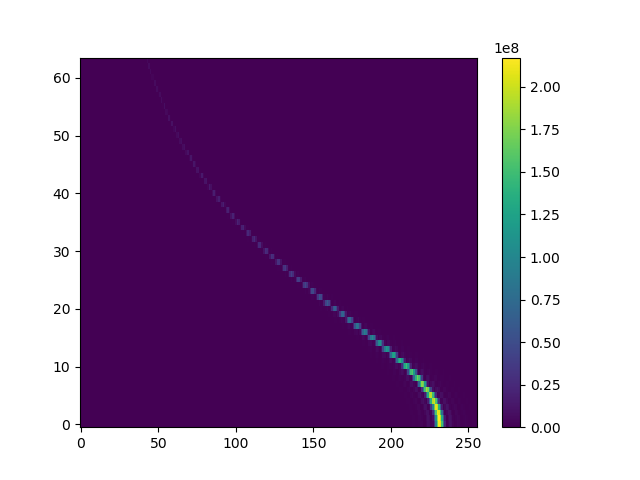

In [7]:
plt.figure()

plt.imshow(calc.Data['radiation'].mean(-1).T, origin='lower', aspect='auto')
plt.colorbar()

In [8]:
# Export the whole spectrum to a VTK file

#calc.exportToVTK(lambda0_um=1)

Time (s) | Platform | Device          | precision | natives | stable
:---:    | :---:    | :---:           | :---:     | :---:   | :---:
87.352   | Apple    | CPU i7-4870HQ   | double    | yes     | no
88.349   | Apple    | CPU i7-4870HQ   | double    | no      | no
22.359   | Apple    | CPU i7-4870HQ   | float     | no      | **NO**
15.281   | Apple    | CPU i7-4870HQ   | float     | yes     | **NO**
32.117   | Apple    | Radeon R9 M370X | double    | no      | yes
31.438   | Apple    | Radeon R9 M370X | double    | yes     | yes
04.794   | Apple    | Radeon R9 M370X | float     | no      | yes
01.334   | Apple    | Radeon R9 M370X | float     | yes     | yes

**NO** means actually produces the wrong results